In [84]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import csv

data = []

with open("./data/" + "frederiksberg" + ".csv", mode='r') as file:
    content = csv.reader(file)

    for line in content:
        lst = []
        lst.append(line[5])
        if not line[10] : continue
        
        for i in range (10,30*2): #10-29
            if (i % 2 == 0): lst.append(line[i])
            else : continue
        data.append(lst)

# Removed verbose printing to avoid noisy output


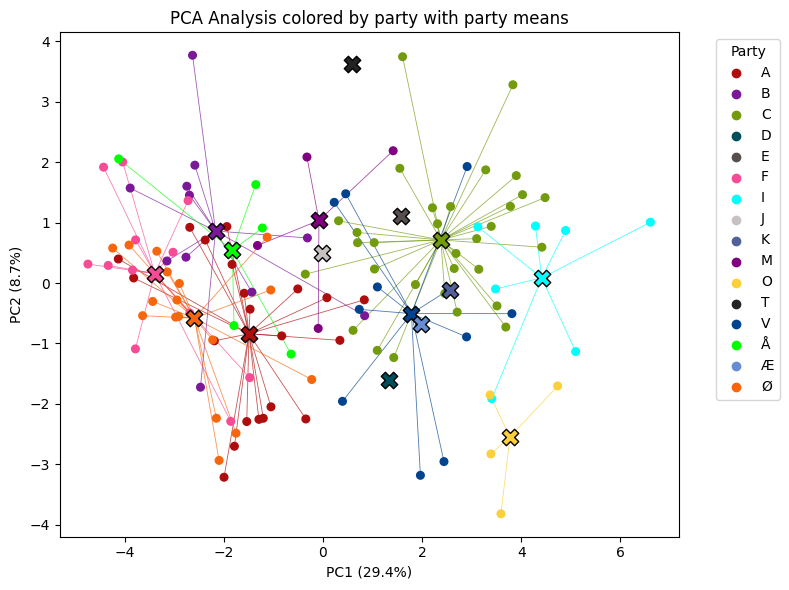

In [85]:
# Filter out any rows where the party value is literally 'party' (case-insensitive)
filtered = [row for row in data if not (isinstance(row[0], str) and row[0].strip().lower() == 'party')]

# Prepare parties and features from filtered data (each row: party, features...)
parties = [row[0] for row in filtered]
# Build feature matrix, converting to float and replacing missing with NaN
features = []
for row in filtered:
    feat = []
    for v in row[1:]:
        try:
            feat.append(float(v))
        except Exception:
            feat.append(np.nan)
    features.append(feat)
features = np.array(features, dtype=float)
# Replace NaNs with 0.0 (or choose a different imputation strategy)
features = np.nan_to_num(features, nan=0.0)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# ---- Color mapping: hardcode party colors here ----
# Edit `party_color_map` to assign exact colors for parties.
party_color_map = {
    'A': '#AF0D0D',
    'B': '#7A1898',
    'C': '#729B0D',
    'D': '#00505B',
    'E':  '#564F4E',
    'F': '#F74B95',
    'I': 'cyan',
    'J': '#C7C2C1',
    'K': '#53619B',
    'M': 'purple',
    'O': '#FCD03B',
    'V': '#01438E',
    'T': '#252322',
    'Å': '#00FF00',
    'Æ': '#668dd1',
    'Ø': '#F7660D'
}

# Map unique parties to colors, preferring the hardcoded map and
# falling back to a colormap for unmapped parties.
unique_parties = sorted(set(parties))
cmap = plt.get_cmap('tab20')
colors = {}
for i, p in enumerate(unique_parties):
    if p in party_color_map:
        colors[p] = party_color_map[p]
    else:
        colors[p] = cmap(i % cmap.N)

point_colors = [colors[p] for p in parties]

# Visualize candidates
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=point_colors, s=30, zorder=2)

# For each party: compute mean point, draw thin lines to each candidate, and plot mean
party_means = {}
coords = np.array(pca_result)
party_array = np.array(parties)
for p in unique_parties:
    idx = np.where(party_array == p)[0]
    if idx.size == 0:
        continue
    pts = coords[idx]
    mean_pt = pts.mean(axis=0)
    party_means[p] = mean_pt
    # draw lines from mean to each candidate
    for pt in pts:
        plt.plot([mean_pt[0], pt[0]], [mean_pt[1], pt[1]], color=colors[p], linewidth=0.6, alpha=0.7, zorder=1)
    # plot mean point on top
    plt.scatter(mean_pt[0], mean_pt[1], color=colors[p], edgecolor='k', s=140, marker='X', zorder=3)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.title("PCA Analysis colored by party with party means")
# Build legend entries (one per party)
for p in unique_parties:
    plt.scatter([], [], color=colors[p], label=p)
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
